# Optimization for the prime twist

As a beginner as a data scientist, I have to face up the fact that I won't be able to rank high enough to get the bounty... I propose you a solution to optimize a given path taking into account the carrot rule. The basic idea is to check the surroundings of every 10th step to see if there's a prime city worthy to swap it with the city Santa is coming from. I did not take the time to translate all my comments in english, but here's a schema how it's done:

https://docs.google.com/drawings/d/1PxKsnE6rQopUf-CFOi1NpY7BLupDoFv3bm7NQ7-C5DQ/edit?usp=sharing

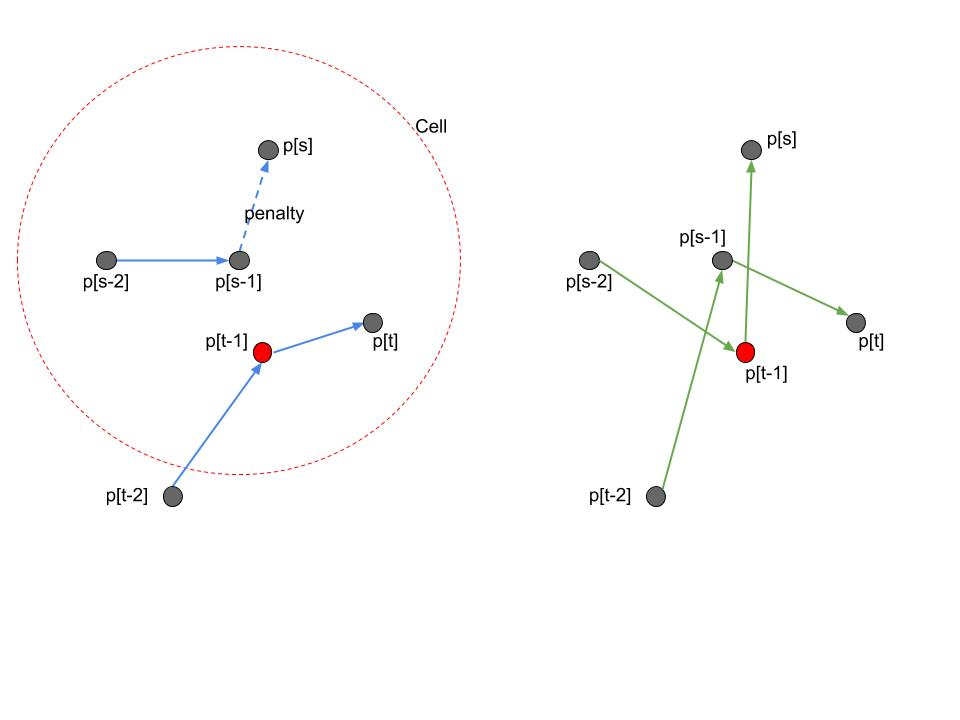

Swap is done between p[s-1] and a prime city located in the path at p[t-1] when the green path is shorter than the blue path (with penalyt). We add a couple of conditions to do it and take into account two limits cases when t=s-1 and t=s+1 (in this two cases we will have to work on 4 points).
Code isn't completely optimized, especially if there are several primes (except the 2 limits cases). And there's certainly room for improvement..

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sympy.ntheory.primetest import isprime
from numba import jit
from math  import sqrt

## Chargement des données 

In [ ]:
# Chargement des données et ajout d'une colonne indiquant si le numéro de la ville est un nombre premier
# Dataframe utilisé comme variable globale
cities = pd.read_csv('../input/traveling-santa-2018-prime-paths/cities.csv')
cities['IsPrime'] = cities['CityId'].apply(isprime)

In [ ]:
cities.head()

## Fonction de calcul du score

Définition d'une fonction de calcul de score avec optimisation de Numba
`from numba import jit
@jit(nopython=True, parallel = True)`
Ne fonctionne pas avec Pandas

In [ ]:
def compute_score(path):
    # path: list
    path = path[ : len(path)-1] # Retirer le retour au dernier point (0)
    cities_path = cities.reindex(path)
    isPrime = cities_path.IsPrime.values
    coord   = cities_path[['X', 'Y']].values
    return compute_score_fast(coord, isPrime)

In [ ]:
@jit(nopython=True, parallel=True)
def compute_score_fast(coord, isPrime):
    # coord: matrix float, isPrime vector boolean
    score = 0
    city_start_coord = coord[0]

    for step in range(1,len(coord)):
        city_end_coord = coord[step]
        distance_step = distance(city_start_coord, city_end_coord)
        if step%10 == 0 and  not isPrime[step-1]:
            distance_step = 1.1 * distance_step

        score = score + distance_step
        
        # La ville d'arrivée est la nouvelle ville de départ
        city_start_coord = city_end_coord
    
    # Retour au pôle nord coord[0]
    # (Pb si le retour au pôle nord se fait sur une étape %10, a priori pas le cas avec la map donnée )
    score = score + distance(city_start_coord, coord[0])
    
    return score

In [ ]:
@jit(nopython=True, parallel=True)
def distance(a, b):
    return sqrt( pow(b[0] - a[0], 2) + pow(b[1] - a[1], 2))

## Score de la solution initiale
Récupération d'un chemin déjà performant
[jsaguiar/lkh-solver](https://www.kaggle.com/jsaguiar/lkh-solver)

In [ ]:
path_init = pd.read_csv('../input/lkh-solver/submission.csv')['Path'].tolist()
score_init = compute_score(path_init)
score_init

## Voisinage de la ville de départ de la %10ème étape

Recherche de villes nombres premiers aux alentours et permutation s'il y a un gain de distance

In [ ]:
path = path_init
path = path[ : len(path)-1]
cities_path = cities.reindex(path)
cityId  = cities_path.CityId.values
isPrime = cities_path.IsPrime.values
coord   = cities_path[['X', 'Y']].values
cities_path.tail()

### Conditions aux limites
Cas où t=s-1 et où t=s+1

In [ ]:
# Permutation dans le cas t= s-1
for s in range(1,len(path)):
    if s%10 == 0 and not isPrime[s-1]:

        t = s-1
        if isPrime[t-1]:
            # Travail sur 4 points
            d_10thstep_old = distance(coord[s-3], coord[s-2]) + distance(coord[s-2], coord[s-1]) + distance(coord[s-1], coord[s]) * 1.1
            d_10thstep_new = distance(coord[s-3], coord[s-1]) + distance(coord[s-1], coord[s-2]) + distance(coord[s-2], coord[s])
            
            if d_10thstep_new < d_10thstep_old :
                gain = d_10thstep_new - d_10thstep_old
                print(s, " gain: ", gain, "  -- t = ", t)
                path[t-1] , path[s-1]       = path[s-1] , path[t-1]
                isPrime[t-1] , isPrime[s-1] = isPrime[s-1] , isPrime[t-1]
                coord[t-1] , coord[s-1]     = coord[s-1] , coord[t-1]
print("Done")


In [ ]:
# Permutation dans le cas t= s-1

for s in range(1,len(path)):
    if s%10 == 0 and not isPrime[s-1]:

        t = s+1
        if isPrime[t-1]:
            # Travail sur 4 points
            d_10thstep_old = distance(coord[s-2], coord[s-1]) + distance(coord[s-1], coord[s])*1.1 + distance(coord[s], coord[s+1])
            d_10thstep_new = distance(coord[s-2], coord[s]) + distance(coord[s], coord[s-1]) + distance(coord[s-1], coord[s+1])
            
            if d_10thstep_new < d_10thstep_old :
                gain = d_10thstep_new - d_10thstep_old
                print(s, " gain: ", gain, "  -- t = ", t)
                path[t-1] , path[s-1]       = path[s-1] , path[t-1]
                isPrime[t-1] , isPrime[s-1] = isPrime[s-1] , isPrime[t-1]
                coord[t-1] , coord[s-1]     = coord[s-1] , coord[t-1]
            
print("Done")


In [ ]:
## Cas général

In [ ]:
for s in range(1,len(path)):
    if s%10 == 0 and not isPrime[s-1]:
        # s: indice d'une ville traversée au 10ème pas
        # Intervalle de recherche d'un nombre premier: [path[s-1]-d, path[s-1]+d]
        x0 = coord[s-1][0]
        y0 = coord[s-1][1]
        # "Rayon" de recherche : path[s-2] -> path[s-1] -> path[s] avec pénalité
        d = distance(coord[s-2], coord[s-1]) + distance(coord[s-1], coord[s]) * 1.1
        
        # Récupération des nombres premiers dans la cellule correspondante
        cell = cities[(cities.X > x0-d ) & (cities.X < x0+d)]
        cell = cell[(cell.Y > y0-d ) & (cell.Y < y0+d)]
        cell = cell[cell.IsPrime]
                
        coord_primes_arround = cell[['X','Y']].values
        cityId_primes_arround = cell.CityId.values
        
        for j in range(len(cell)):
            d_10thstep_old = distance(coord[s-2], coord[s-1]) + distance(coord[s-1], coord[s]) * 1.1
            # Pas de prise en compte d'optimisation dans le cas de multiples options

            # index dans path de la ville nombre premier appartenant au voisinage : t-1
            t = path.index(cityId_primes_arround[j]) + 1 # cf schéma
            if (t%10 != 0) and (t!=s-1) and (t!=s+1) : 
                # On ne fait pas permutation si la ville ciblée est déjà le point de départ d'une 10ème étape
                # Les cas limites sont traités à part
                d_prime_old = distance(coord[t-2], coord[t-1]) + distance(coord[t-1], coord[t])

                d_10thstep_new = distance(coord[s-2], coord[t-1]) + distance(coord[t-1], coord[s])
                d_prime_new    = distance(coord[t-2], coord[s-1]) + distance(coord[s-1], coord[t])
                
                # Ajout de la pénalité si t-2 n'est pas premier et t-1 %10
                if  not isprime(cityId[t-2]) and (t-1)%10==0 :
                    d_prime_old = distance(coord[t-2], coord[t-1])*1.1 + distance(coord[t-1], coord[t])
                    d_prime_new = distance(coord[t-2], coord[s-1])*1.1 + distance(coord[s-1], coord[t])

                d_old = d_10thstep_old + d_prime_old
                d_new = d_10thstep_new + d_prime_new
                
                if d_new < d_old :
                    gain = d_new - d_old
                    print(s, " gain: ", gain, "  -- t = ", t)
                    # Amélioration choisir le min quand il y a plusieurs choix
                    path[t-1] , path[s-1]       = path[s-1] , path[t-1]
                    isPrime[t-1] , isPrime[s-1] = isPrime[s-1] , isPrime[t-1]
                    coord[t-1] , coord[s-1]     = coord[s-1] , coord[t-1]
                    
                    
print("Done")

In [ ]:
path.append(0)
score_final = compute_score(path)
print(score_final - score_init)

## Code pour proposer une solution

In [ ]:
pd.DataFrame({'Path':path}).to_csv('submission.csv', index=False)